In [8]:
import numpy as np
import pandas as pd
import coupled_LDS
import scipy.stats as stats
import scipy.linalg
from utils import *
import matplotlib.pyplot as plt
from plotting_utils import *
import autograd.numpy as anp 
import os
from sippy_unipi import *
from sklearn.linear_model import LinearRegression
import scipy.linalg as sl
from coupled_LDS import *
from EI_subspace_RNN import * 

K1 = 3
K2 = 1

# Generate EI RNN

In [9]:
U = 500
T = 100
K = K1 + K2
D = 50
M = 2
N_e = int(D/2) # number of units in the RNN
N_i = int(D/2)
N = N_e + N_i
sparsity = 0.25     
N_weights = int (N * N * sparsity)

LDS = coupled_LDS(D, K1, K2, M)    
# generate known inputs 
u = LDS.generate_inputs(U,T)

        

In [10]:
np.random.seed(52)
G = np.random.normal(0, 1, (D,D))
G, _ = np.linalg.qr(G)  # QR decomposition, Q is the orthogonal matrix
Um = G[:,:K1] # D x K1 orthogonal matrix
Um_n = G[:,:K2] # D x K2 orthogonal matrix, K2 <= K1
print(G[:,K2:K1].shape)
print(G[:,K1:K1+K2].shape)
Un = np.concatenate([G[:,K2:K1],G[:,K1:K1+K2]], axis=1)

# print(np.linalg.matrix_rank(Um))
# print(np.linalg.matrix_rank(Un))
# print(np.linalg.matrix_rank(Um_n))
# print(np.linalg.matrix_rank(np.concatenate([Un,Um], axis=1)))

Mw = np.zeros((D,K1))
Nw = np.zeros((D,K1))

# sample independent columns of M based on U_m
for i in range(K1):
    np.random.seed(2*i)
    alphas = np.random.uniform(0,1,size=K1).reshape((1,K1))
    Mw[:,i] = (alphas @ Um.T).flatten() / np.sum(alphas)

    np.random.seed(2*i+1)
    betas = np.random.uniform(0,1,size=K1).reshape((1,K1))
    Nw[:,i] = (alphas @ Un.T).flatten() / np.sum(betas)

print(np.linalg.matrix_rank(Mw))
print(np.linalg.matrix_rank(Nw))
print(np.linalg.matrix_rank(np.concatenate([Mw,Um], axis=1)))
print(np.linalg.matrix_rank(np.concatenate([Nw,Un], axis=1)))
print(np.linalg.matrix_rank(np.concatenate([Mw,Nw], axis=1)))



(50, 2)
(50, 1)
3
3
3
3
4


In [11]:
true_A = np.zeros((K1+K2,K1+K2))
true_A[:K1,:K1] = Un.T @ Mw @ Nw.T @ Un # A11
true_A[K1:,:K1] = Um_n.T @ Mw @ Nw.T @ Un # A21

# Generate Low-Rank RNN

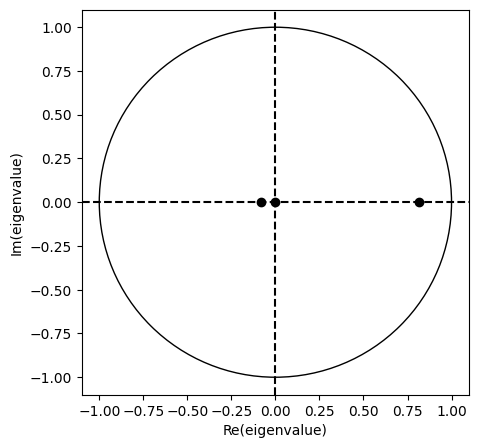

In [12]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(true_A[:K1,:K1]),[])

In [13]:
true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R = LDS.generate_other_parameters()
true_x, true_y = LDS.generate_latents_and_observations(U, T, u, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)


In [14]:
max_S = 200
method = "MOESP"
U = u[:max_S].reshape(-1, M).T
true_y_zerom = true_y[:max_S]-np.mean(true_y[:max_S], axis=(0,1), keepdims=True)
Y = true_y_zerom.reshape(-1, D).T
sys_id = system_identification(Y, U, method, SS_fixed_order=K, SS_p=2*K,             # past block‐rows
SS_f=2*K)
Q, R = np.linalg.qr(sys_id.C, mode='reduced')   
P = np.linalg.inv(R)                     
C_orth = sys_id.C @ P # to get C orthogonal
A_hat = R @ sys_id.A @ P
A_Schur, V = sl.schur(A_hat.T, output='real')
A_Schur = A_Schur.T

In [19]:
init_B, init_Q, init_mu0, init_Q0, _, init_d, init_R = LDS.generate_other_parameters()
# ecll_new, ecll_old, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, A_Schur, init_B, init_Q, init_mu0, init_Q0, C_orth, init_d, init_R, max_iter=100, verbosity=0)
ecll_new, ecll_old, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, A, B, Q , mu0, Q0, C, d, R, max_iter=50, verbosity=0)



0
10
20
30
40


(100,)


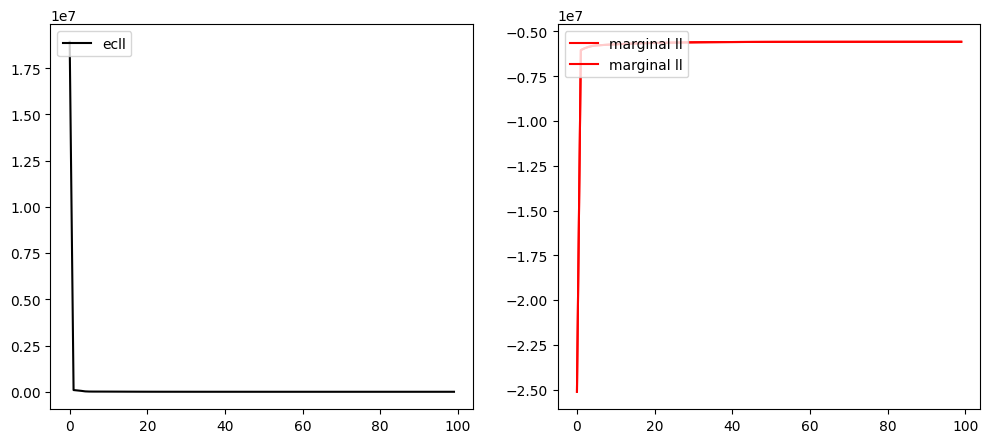

In [16]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
print(ll.sum(axis=1).shape)
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll')
axes[1].plot(elbo, color='red', label='marginal ll')
axes[1].plot(ll.sum(axis=1), color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

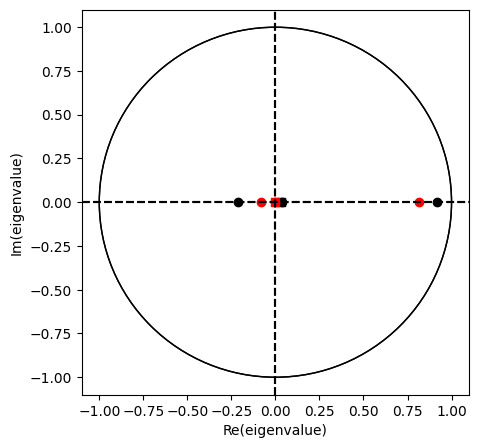

In [17]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]))
plot_eigenvalues(axes, np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='red')

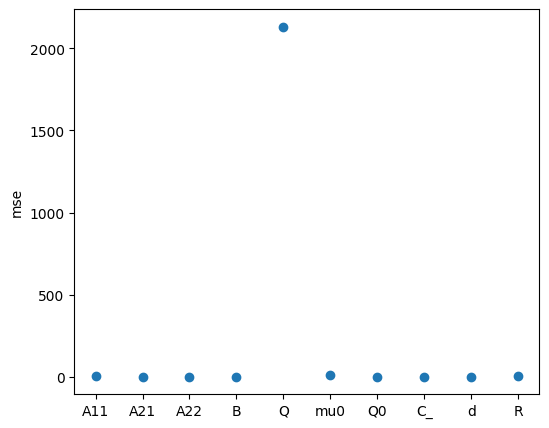

In [18]:
fig, axes = plt.subplots(figsize=(6,5))
plot_mse_parameters(axes, K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)